In [2]:
import torch
import os
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torchvision.datasets import ImageFolder
import glob
import copy
import matplotlib.gridspec as gridspec
# Установка флага cudnn.benchmark для улучшения производительности на GPU
cudnn.benchmark = True

In [2]:
# Путь к директории с данными
data_dir = 'data'


In [3]:
# Определение преобразований для обучающего и валидационного наборов данных
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),  # Изменение размера изображения
        transforms.RandomRotation(10),  # Случайное вращение изображения на 10 градусов
        transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
        transforms.ToTensor(),  # Преобразование в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация изображения
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),  # Изменение размера изображения
        transforms.ToTensor(),  # Преобразование в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация изображения
    ]),
}

In [5]:
# Создание наборов данных ImageFolder для обучающего и валидационного наборов
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# Получение классов изображений
class_names = image_datasets['train'].classes

In [6]:
# Создание загрузчиков данных для обучающего и валидационного наборов
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}

In [7]:
# Получение размеров обучающего и валидационного наборов данных
dataset_sizes = {x: len(image_datasets[x]) 
              for x in ['train', 'val']}

In [8]:
# Определение устройства (GPU или CPU)
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [9]:
!nvidia-smi

Sun Feb 11 16:55:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:05:00.0  On |                  N/A |
|  0%   43C    P8              22W / 170W |    744MiB / 12288MiB |     51%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
# Загрузка предварительно обученной модели EfficientNet
model_ft = models.efficientnet_b4(pretrained=True) 
# Изменение последнего слоя модели
num_ftrs = model_ft.classifier[1].in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

d:\Games\123\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Games\123\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Установка шедулера для изменения скорости обучения
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=14):
    since = time.time()
    #Сохраняем  лучшие веса 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 99
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # перенос  вычислений на куду 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    acc = (torch.sum(preds == labels.data)) / len(inputs)

                    # считаем градиенты тольок если трейн данные 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # стасистика  
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # сохраняем лучшие веса 
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')
    

    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Обучение модели
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)
# Сохранение весов модели с лучшей валидационной потерей
torch.save(model_ft,'efinet-bestloss.pth')
torch.save(model_ft.state_dict(), "weights.pth")

Epoch 0/9
----------
train Loss: 2.1691 Acc: 0.3646
val Loss: 1.2964 Acc: 0.5603

Epoch 1/9
----------
train Loss: 1.2872 Acc: 0.5728
val Loss: 1.1108 Acc: 0.6377

Epoch 2/9
----------
train Loss: 0.9892 Acc: 0.6696
val Loss: 0.9862 Acc: 0.6795

Epoch 3/9
----------
train Loss: 0.7756 Acc: 0.7379
val Loss: 1.0196 Acc: 0.6802

Epoch 4/9
----------
train Loss: 0.6113 Acc: 0.7923
val Loss: 1.0022 Acc: 0.6931

Epoch 5/9
----------
train Loss: 0.4522 Acc: 0.8484
val Loss: 1.0824 Acc: 0.7088

Epoch 6/9
----------
train Loss: 0.3800 Acc: 0.8716
val Loss: 1.0757 Acc: 0.7013

Epoch 7/9
----------
train Loss: 0.2192 Acc: 0.9265
val Loss: 1.0722 Acc: 0.7256

Epoch 8/9
----------
train Loss: 0.1666 Acc: 0.9440
val Loss: 1.1305 Acc: 0.7304

Epoch 9/9
----------
train Loss: 0.1487 Acc: 0.9486
val Loss: 1.1888 Acc: 0.7306

Training complete in 141m 19s
Best val Loss: 0.986238


In [ ]:
# Загрузка предварительно обученной модели EfficientNet
model = models.efficientnet_b4(pretrained=True)

# Загрузка весов из состояния словаря
state_dict = torch.load('weights.pth', map_location=torch.device('cpu'))

# Удаление ключей, соответствующих полносвязному слою
state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}

# Загрузка состояния словаря в модель
model.load_state_dict(state_dict, strict=False)




# Оценка производительности на тестовом наборе данных
test_dataset = datasets.ImageFolder('/загрузки/data/val', transform=data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs
            labels = labels
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return accuracy, all_preds, all_labels

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.6321
Recall: 0.6099
F1 Score: 0.6081


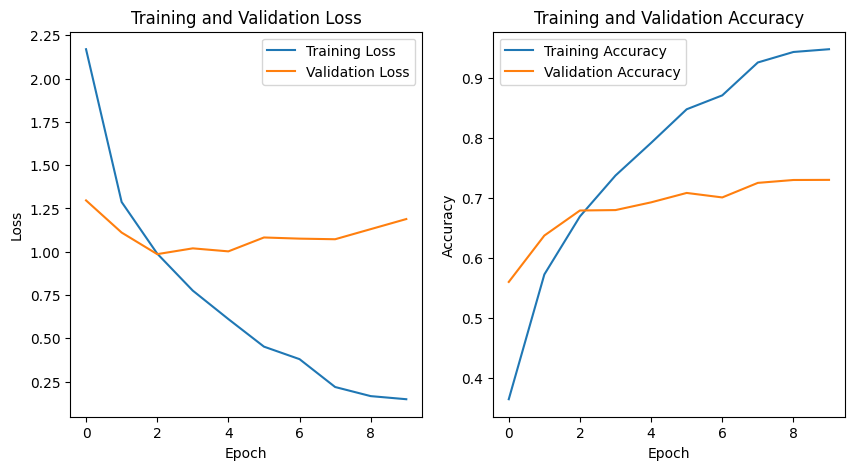

In [3]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

train_loss_history = [2.1691, 1.2872, 0.9892, 0.7756, 0.6113, 0.4522, 0.3800, 0.2192, 0.1666, 0.1487]
val_loss_history = [1.2964, 1.1108, 0.9862, 1.0196, 1.0022, 1.0824, 1.0757, 1.0722, 1.1305, 1.1888]
train_acc_history = [0.3646, 0.5728, 0.6696, 0.7379, 0.7923, 0.8484, 0.8716, 0.9265, 0.9440, 0.9486]
val_acc_history = [0.5603, 0.6377, 0.6795, 0.6802, 0.6931, 0.7088, 0.7013, 0.7256, 0.7304, 0.7306]

plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)